In [174]:
import pandas as pd 
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random as rnd
from networkx.algorithms import community
from collections import Counter
import re
import math
import heapq
import time
import copy

In [175]:
nodes = pd.read_csv('nodes.csv').loc[:,['id','label','born','died','continental','analytic']]
nodes = nodes[(nodes.continental == 1) | (nodes.analytic == 1)]
lone_nodes = ['n130', 'n478','n486','n489']
nodes = nodes[(nodes.id.isin(lone_nodes) == False)]

edges = pd.read_csv('edges.csv')
edges = edges[(edges['from'].isin(nodes.id)) & (edges['to'].isin(nodes.id))]

In [176]:
edges.to_csv('dedges.csv')

In [177]:
G = nx.Graph() 
color_map = []

for index, row in nodes.iterrows():

    if row.continental == 1:
        color_map.append('blue')
    elif row.analytic == 1:
        color_map.append('red')
    else: color_map.append('yellow')

    G.add_node(
        row.id, 
        label = row.label,
        born = row.born,
        died = row.died
    )

for index, row in edges.iterrows():

    G.add_edge(row['from'], row['to'])

In [178]:
pos = nx.spring_layout(G)

options = {
    'node_color': color_map,
    'node_size': 50,
    'width': 1
}

#nx.draw(G, **options, with_labels=False, pos = pos)

In [179]:
def create_comms(partition, name):

    ordered = []
    done = False

    if type(partition) is not tuple:
        while not done:
            done = True
            for g in range(0,len(partition)-1):
                if len(partition[g]) < len(partition[g+1]):
                    temp = partition[g+1]
                    partition[g+1] = partition[g]
                    partition[g] = temp
                    done = False

    for g in range(0,len(partition)):
        comm = name + str(g)
        nodes[comm] = [1 if n in list(partition[g]) else 0 for n in nodes.id]

def iter_comms(iterator, name):
    array = []
    for i in iterator:
        array.append(list(i))
    
    create_comms(array, name)


In [180]:
display(nodes)

,id,label,born,died,continental,analytic
21,n22,Edmund Husserl,1859-04-08 00:00:00,1938-04-27 00:00:00,1,0
51,n52,Bertrand Russell,1872-05-18 00:00:00,1970-02-02 00:00:00,0,1
54,n55,Martin Heidegger,1889-09-26 00:00:00,1976-05-26 00:00:00,1,0
56,n57,Xavier Zubiri,1898-12-04 00:00:00,1983-09-21 00:00:00,1,0
62,n63,Georg Wilhelm Friedrich Hegel,1770-08-27 00:00:00,1831-11-14 00:00:00,1,0
...,...,...,...,...,...,...
672,n673,David Stove,1927-09-15 00:00:00,1994-06-02 00:00:00,0,1
675,n676,Mladen Dolar,1951-01-29 00:00:00,NaN,1,0
686,n687,Stephen Darwall,1946-01-01,NaN,0,1
689,n690,Patrick Suppes,1922-03-17 00:00:00,2014-11-17 00:00:00,0,1


In [181]:
comms = []
for index, row in nodes.iterrows():
    comms.append(','.join(list(row[row == 1].keys())))
nodes['comms'] = comms

In [182]:
display(nodes)
nodes.to_csv('dnodes.csv')

,id,label,born,died,continental,analytic,comms
21,n22,Edmund Husserl,1859-04-08 00:00:00,1938-04-27 00:00:00,1,0,continental
51,n52,Bertrand Russell,1872-05-18 00:00:00,1970-02-02 00:00:00,0,1,analytic
54,n55,Martin Heidegger,1889-09-26 00:00:00,1976-05-26 00:00:00,1,0,continental
56,n57,Xavier Zubiri,1898-12-04 00:00:00,1983-09-21 00:00:00,1,0,continental
62,n63,Georg Wilhelm Friedrich Hegel,1770-08-27 00:00:00,1831-11-14 00:00:00,1,0,continental
...,...,...,...,...,...,...,...
672,n673,David Stove,1927-09-15 00:00:00,1994-06-02 00:00:00,0,1,analytic
675,n676,Mladen Dolar,1951-01-29 00:00:00,NaN,1,0,continental
686,n687,Stephen Darwall,1946-01-01,NaN,0,1,analytic
689,n690,Patrick Suppes,1922-03-17 00:00:00,2014-11-17 00:00:00,0,1,analytic


In [183]:
def color_gen(name, title):

    color_map = []

    for index, row in nodes.iterrows():
        if row[name + '0'] == 1:
            color_map.append('blue')
        elif row[name + '1'] == 1:
            color_map.append('red')
        else: color_map.append('yellow')

    options = {
        'node_color': color_map,
        'node_size': 50,
        'width': 1
    }
    
    nx.draw(G, **options, with_labels=False, pos = pos)
    plt.title(title)
    plt.show()
    display(pd.crosstab(nodes.continental, nodes[name + '0'], rownames = ['Actual'], colnames = ['Predicted']))

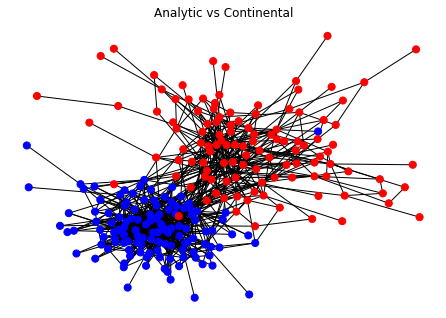

In [184]:
nx.draw(G, **options, with_labels=False, pos = pos)
plt.title('Analytic vs Continental')
plt.show()

## Kernighan-Lin Bisection

This method wasn't originally intended to be a community detection algorithm, rather, its purpose was to divide a graph into two partitions with the minimal number of connections between the partitions. In the original paper (http://xilinx.asia/_hdl/4/eda.ee.ucla.edu/EE201A-04Spring/kl.pdf), the example they use are circuit boards. The components of an electronic circuit are printed onto multiple circuit cards but connections between these cards are relatively costly. Therefore, finding ways to divide these connected components onto different cards with minimal cross-card connections was desirable.

This heuristic method can be used effectively for community detection when you know a graph contains two similarily sized groups. Luckily this is the case with the philosopher subnetwork of analytical and continental philosophers. This method starts by bisecting the graph into two separate groups of nodes, usually at random. Then for each node it calculates the number of edges it shares with its ingroup and its outgroup. To reduce the number of edges between groups it's best to have minimal outgroup edges. On the otherhand, having many ingroup edges means if the node was moved into the other group it would then have many outgroup edges which is undesirable. Therefore, this method takes the difference between the number of outgroup edges and ingroup edges as it's heuristic (D = OUT - IN). For each group it finds the nodes with the maximal difference between their number of outgroup edges and ingroup edges then swaps them. This is the optimal single swap for minimizing outgroup edges. It then recalculates the number of ingroup edges and outgroup edges for every node and again identifies the optimal swap. It can repeat this n times and approaches an optimal solution. 

https://en.wikipedia.org/wiki/Kernighan%E2%80%93Lin_algorithm


In [185]:
def n_adjacents(node, nset):

    ctr = 0

    for n in G.neighbors(node):
        if n in nset: ctr = ctr + 1
    
    return ctr

def set_inout_difference(inset, outset):

    for node in inset:
        inset[node] = n_adjacents(node, outset) - n_adjacents(node, inset)

def klb(G, iter):

    rand = [i for i in range(G.number_of_nodes())]
    rnd.shuffle(rand)

    set1 = {}
    set2 = {}

    for i in range(len(rand)):
        if i < len(rand) / 2:
            set1[list(G.nodes)[rand[i]]] = None
        else: set2[list(G.nodes)[rand[i]]] = None

    for i in range(iter):

        set_inout_difference(set1,set2)
        set_inout_difference(set2,set1)
        
        n1 = max(set1, key = set1.get)
        n2 = max(set2, key = set2.get)

        set1.pop(n1)
        set2.pop(n2)

        set1[n2] = None
        set2[n1] = None

    return [set1, set2]




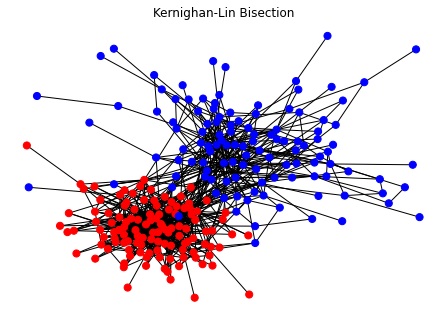

Predicted,0,1
Actual,,
0,2,113
1,116,4


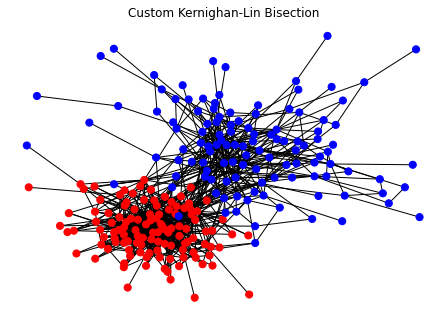

Predicted,0,1
Actual,,
0,2,113
1,115,5


In [186]:
create_comms(community.kernighan_lin_bisection(G, max_iter = 500), 'klb')
create_comms(klb(G, 500), 'custom_klb')
color_gen('klb', 'Kernighan-Lin Bisection')
color_gen('custom_klb', 'Custom Kernighan-Lin Bisection')

## Clauset Newman Moore Greedy Algorithm

This algorithm is a greedy agglomerative method that was initially developed to work on large networks with relative efficiency. It has a significant computational advantage over a previous algorithm which optimized for modularity. It's runtime is O(mdlog(n)) where m is the number of edges, d is the hierachical depth of the community structure, and n is the number of nodes. For sparse, hierarchical networks (i.e. m ~ n and d ~ log(n)) this runs in near linear time O(nlog(n)^2). In the original paper (http://ece-research.unm.edu/ifis/papers/community-moore.pdf) they use a massive network with 400,000 vertices and 2 million edges which was previously unassailble by the original algorithm.

This algorithm starts with every node in a network as a community of its own. It then then iterativley combines two neighboring communities such that it maximizes the modularity of the network. The modularity of the network is a heuristic that compares the number of edges within a community to what would be expected in a random network with the same number of nodes and edges. The higher the modularity, the more densely connected the communities in the network are. A "good" breakdown of a network into communities should have a high modularity. This algorithm optimizes on modularity by initially calculating the change in modularity that would occur if it were to combine each pair of communities in the network. The pair with the largest positive change in modularity is combined into an aggregated community (hence it's "greedy") that sums the component communities edges. Then the network is updated by calculating the change in modularity that would occur for combining the new community with any of the ones that were initially neighboring the component communities and then removing the component communities. The algorithm continues until there is just one community but the hierachical community structure is saved. The breakdown that has the highest modularity is the "solution". 

In [187]:
def connected(n1, n2, G):
    return n1 in G.neighbors(n2)

def modularity(c1, c2, G):

    c = 1 / (2 * G.number_of_edges())

    summation = 0

    for v in G.nodes:
        for w in G.nodes:
            a = connected(v, w, G)
            summation = summation + (a - G.degree(v) * G.degree(w) * c)
    
    return c * summation

class mod_matrix:

    def __init__(self, G):

        self.graph = G
        self.matrix = {}
        self.max = [-1, None, None]
        self.comm = 0
        self.communities = {}
        self.modularity = [0]

        constant = 1 / (2 * G.number_of_edges())

        for v in G.nodes:
            row = [G.degree(v),{}]
            for w in G.nodes:
                if connected(v, w, G):
                    temp = constant - (G.degree(v) * G.degree(w) * pow(constant, 2))
                    row[1][w] = temp

                    if temp > self.max[0]: 
                        self.max[0] = temp
                        self.max[1] = v
                        self.max[2] = w
                
            self.matrix[v] = row

    def find_max(self):

        self.max = [-1, None, None]

        for row in self.matrix:
            for col in self.matrix[row][1]:
                if self.matrix[row][1][col] > self.max[0]:
                    self.max[0] = self.matrix[row][1][col]
                    self.max[1] = row
                    self.max[2] = col

    def optimum_join(self):

        constant = 1 / (2 * (self.graph.number_of_edges()**2))

        v1 = self.max[1]
        v2 = self.max[2]
        new_comm = 'c' + str(self.comm)

        self.communities[new_comm] = [v1, v2]
        self.modularity.append(self.modularity[-1] + self.max[0])

        for row in self.matrix:
            if not row in self.max:

                if v1 in self.matrix[row][1] and v2 in self.matrix[row][1]:
                    self.matrix[row][1][new_comm] = self.matrix[row][1][v1] + self.matrix[row][1][v2]
                    self.matrix[row][1].pop(v1)
                    self.matrix[row][1].pop(v2)
                elif v1 in self.matrix[row][1]:
                    self.matrix[row][1][new_comm] = self.matrix[row][1][v1] - constant * self.matrix[row][0] * self.matrix[v2][0]
                    self.matrix[row][1].pop(v1)
                elif v2 in self.matrix[row][1]:
                    self.matrix[row][1][new_comm] = self.matrix[row][1][v2] - constant * self.matrix[row][0] * self.matrix[v1][0]
                    self.matrix[row][1].pop(v2)
        
        new_row = [self.matrix[v1][0] + self.matrix[v2][0],{}]
        cmb_list = []

        for col in self.matrix[v1][1]:
            if col in self.matrix[v2][1]:
                new_row[1][col] = self.matrix[v1][1][col] + self.matrix[v2][1][col]
                cmb_list.append(col)

        for c in cmb_list:
            self.matrix[v1][1].pop(c)
            self.matrix[v2][1].pop(c)
        
        self.matrix[v1][1].pop(v2)
        self.matrix[v2][1].pop(v1)

        for key in self.matrix[v1][1]:
            self.matrix[v1][1][key] = self.matrix[v1][1][key] - constant * self.matrix[key][0] * self.matrix[v2][0]
        for key in self.matrix[v2][1]:
            self.matrix[v2][1][key] = self.matrix[v2][1][key] - constant * self.matrix[key][0] * self.matrix[v1][0]
        
        new_row[1].update(self.matrix[v1][1])
        new_row[1].update(self.matrix[v2][1])

        self.matrix.pop(v1)
        self.matrix.pop(v2)

        self.matrix[new_comm] = new_row

        self.find_max()
        self.comm = self.comm + 1

    def modularize(self):

        while len(self.matrix) > 1:
            #display(m.matrix)
            #display(m.max)
            self.optimum_join()
            
    def get_comm(self, n_comms):

        last_comm = 'c' + str(self.comm - n_comms)

        comms = []
        terminate = []

        for c in range(1, n_comms):
            if self.communities['c' + str(self.comm - c)][0] not in comms:
                comms.append(self.communities['c' + str(self.comm - c)][0])
            if self.communities['c' + str(self.comm - c)][1] not in comms:
                comms.append(self.communities['c' + str(self.comm - c)][1])
            if 'c' + str(self.comm - c) in comms:
                comms.remove('c' + str(self.comm - c))

        for c in range(len(comms)):
            if 'n' in comms[c]:
                comms[c] = [comms[c]]
            else:
                comms[c] = self.comm_members(comms[c])

        return comms
 
    def comm_members(self, c):

        if 'n' in self.communities[c][0] and 'n' in self.communities[c][1]:
            return [self.communities[c][0], self.communities[c][1]]
        else:

            if 'c' in self.communities[c][0]:
                left = self.comm_members(self.communities[c][0])
            else: 
                left = [self.communities[c][0]]

            if 'c' in self.communities[c][1]:
                right = self.comm_members(self.communities[c][1])
            else:
                right = [self.communities[c][1]]

            return left + right


    def best_comm(self):

        for i in range(1, len(self.modularity)):
            if self.modularity[i-1] > self.modularity[i]:
                return self.get_comm(self.comm - i + 2)
        
        return self.get_comm(2)



In [188]:
G1 = nx.Graph()
G1.add_edge('n1','n2')
G1.add_edge('n1','n3')
G1.add_edge('n1','n4')
G1.add_edge('n2','n3')
G1.add_edge('n3','n4')
G1.add_edge('n3','n5')
G1.add_edge('n5','n6')
G1.add_edge('n5','n7')
G1.add_edge('n5','n8')
G1.add_edge('n6','n7')
G1.add_edge('n7','n8')

G2 = nx.Graph()
G2.add_edge('n1','n5')
G2.add_edge('n2','n5')
G2.add_edge('n3','n5')
G2.add_edge('n4','n5')
G2.add_edge('n5','n6')
G2.add_edge('n6','n7')
G2.add_edge('n7','n8')
G2.add_edge('n7','n9')
G2.add_edge('n7','n10')
G2.add_edge('n5','n11')
G2.add_edge('n11','n7')
G2.add_edge('n6','n11')

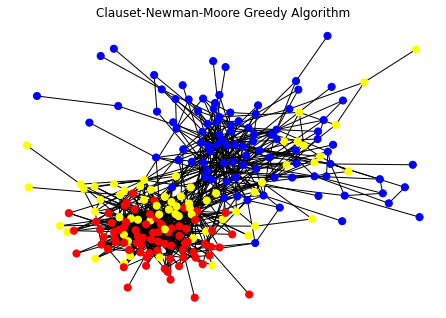

Predicted,0,1
Actual,,
0,22,93
1,117,3


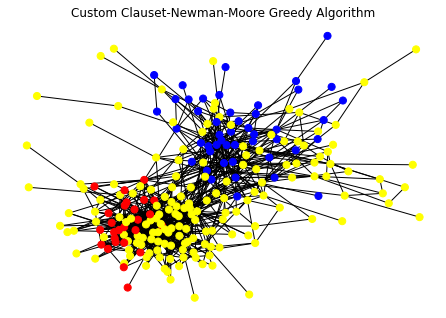

Predicted,0,1
Actual,,
0,68,47
1,120,0


In [189]:
create_comms(community.greedy_modularity_communities(G), 'cnm')
m = mod_matrix(G)
m.modularize()
create_comms(m.best_comm(), 'custom_cnm')
color_gen('cnm', 'Clauset-Newman-Moore Greedy Algorithm')
color_gen('custom_cnm', 'Custom Clauset-Newman-Moore Greedy Algorithm')

## Semi-synchronous Label Propagation

This algorithm attempts to combine the benefits of both synchronous and asynchronous label propagation community detection. Label propagation is a technique in which all nodes are initialized with a unique label then the label for each node is updated to reflect the label of the majority of its neighbors. This algorithm starts by using a graph coloring algorithm to group nodes such that no node is adjacent to any of the other nodes in its group. This allows for semi-synchronous label propagation because all the nodes in a group can be updated asynchronously while the groups can be updated synchronously.

This approach avoids the shortcomings of each previous algorithm, the synchronous approach didn't guarantee termination while the asynchronous performed worse. This algorithm was shown to perform equally well as synchronous and was proven to always terminate. The algorithm starts with grouping the nodes as mentioned above. It can then iterate through each groups' nodes in parallel, updating them based on the labels of their neighbors. It is done sequentially here. When there is a tie for the most common label amongst a node's neighbors one of the labels is chosen at random. The pass over the groups is repeated until all nodes have stopped changing labels or they only change due to a tie.

In [190]:
  
class label_propagator:

    def __init__(self, G):

        self.G = copy.deepcopy(G)
        color = nx.algorithms.greedy_color(self.G)
        nx.set_node_attributes(self.G, color, "color")

        tags = {}
        for n in self.G.nodes:
            tags[n] = n.replace('n', 'l')
        nx.set_node_attributes(self.G, tags, "tag")

        nx.set_node_attributes(self.G, False, "stable")

        self.colors = list({val for val in color.values()})

    def adopt_label(self, node):

        ntags = []
        old_tag = self.G.nodes[node]['tag']

        for n in self.G.neighbors(node):
            ntags.append(self.G.nodes[n]['tag'])
            
        res = self.randMode(ntags, node)

        if old_tag == res['new_tag']:
            nx.set_node_attributes(self.G, {node: {'stable': True}})
        else: 
            nx.set_node_attributes(self.G, {node: {'stable': res['stable']}})

        nx.set_node_attributes(self.G, {node: {'tag': res['new_tag']}})

    def randMode(self, ntags, node):

        c = dict(Counter(ntags))
        m = max(c.values())
        modes = [k for k,v in c.items() if v == m]

        if len(modes) > 1:
            return {'new_tag': rnd.choice(modes), 'stable': True}
        else:
            return {'new_tag': modes[0], 'stable': False}

    def propagate(self):

        temp = copy.deepcopy(self.G)

        for c in self.colors:
            for n in temp.nodes:
                if temp.nodes[n]['color'] == c:
                    self.adopt_label(n)

    def get_groups(self):

        tags = nx.get_node_attributes(lp.G, 'tag')

        temp = {}
        for key, val in tags.items():
            if val in temp:
                temp[val].append(key)
            else:
                temp[val] = [key]
        
        groups = []
        for key, val in temp.items():
            groups.append(val)
        
        return groups

    def solve(self):

        while sum(list(nx.get_node_attributes(self.G, 'stable').values())) < len(self.G.nodes):
            lp.propagate()
        
        return self.get_groups()


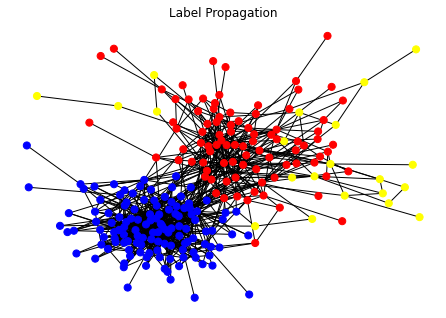

Predicted,0,1
Actual,,
0,109,6
1,2,118


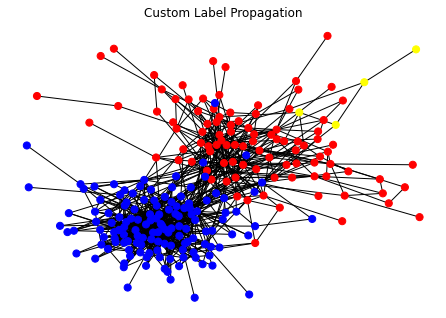

Predicted,0,1
Actual,,
0,99,16
1,2,118


In [191]:
lp = label_propagator(G)
iter_comms(community.label_propagation_communities(G), 'lab')
create_comms(lp.solve(), 'custom_lab')
color_gen('lab', 'Label Propagation')
color_gen('custom_lab', 'Custom Label Propagation')

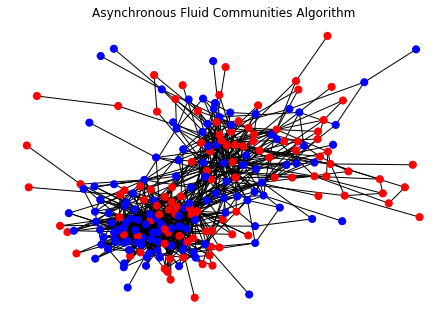

Predicted,0,1
Actual,,
0,58,57
1,52,68


In [192]:
iter_comms(community.asyn_fluidc(G, 2), 'aflu')
color_gen('aflu', 'Asynchronous Fluid Communities Algorithm')

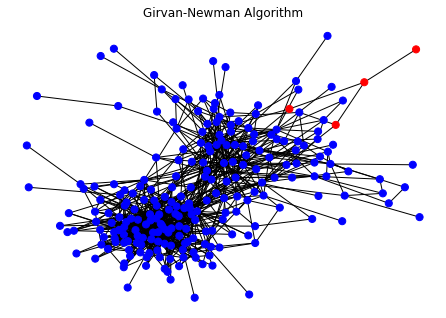

Predicted,0,1
Actual,,
0,4,111
1,0,120


In [193]:
gnew = community.girvan_newman(G)
create_comms(list(sorted(c) for c in next(gnew)), 'gnew')
color_gen('gnew', 'Girvan-Newman Algorithm')